## Problem Set 2
_MaCSS 222 Applied Statistics II_
_Spring 2025_

This Problem Set will, like the first problem set utilize an extract from the 1997 cohort of the National Longitudinal Survey of Youth (NLSY97). This Notebook is designed to help you get started. Serving as a stub for your own solutions, completing the problem set will involve adding code and commentary to this notebook. Narrative answers to questions posed in the Problem Set can be included in markdown boxes in this notebook. For "pencil and paper" calculations you can either hand-write your answers and turn in a pdf-scan of them along with your Python Jupyter Notebook, or you can write you answers in LaTex in markdown boxes. Please see the pdf file for Problem Set 1 for instructions.
<br>
<br>
If you are not already familiar with LaTex, I encourage you to learn the basics. Overleaf is a helpful online editing environment for LaTex which you can access as a UC Berkeley community member.
<br>
<br>
The goals of this particular problem set are two fold. First, to review the basics of logistic regression analysis. Second, to gain practice using the boostrap in more complicated settings -- settings where traditional (i.e., analytic) methods of confidence interval and standard error construction are not possible.

In [13]:
# Load libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

### Part I: Load NLSY97 extract

In [4]:
# Directory where NLSY97 teaching extract file is located
data =  '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Data/'

# Directory to save graphics files in
graphics = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Graphics/'

In [5]:
# Load NLSY97 dataset
nlsy97 = pd.read_csv(data+'nlsy97ss.csv') # Reading .csv as DataFrame

In [6]:
# Rename some columns and then form new dataframe with complete cases for key variables
nlsy97.rename(columns={'avg_earn_2016_to_2020': 'earnings', 'hgc_at_age28': 'yrssch'}, inplace=True)


In [7]:
# Look at first few rows of dataset
nlsy97[0:5]

,hhid97,pid97,swgt,cs_smpl,earnings,yrssch,asvab,female,black,hispanic,birth_month,birth_year
0,2,2,272178,1,140764.964069,14.0,58.483,0,0,1,July,1982
1,3,3,169357,1,34487.266323,14.0,27.978,1,0,1,September,1983
2,4,4,149099,1,45864.738658,13.0,37.012,1,0,1,February,1981
3,8,6,218371,1,23202.102210,14.0,22.001,1,0,1,January,1982
4,8,7,232055,1,0.000000,12.0,3.585,0,0,1,April,1983


### Part II: Predicting college attendance among those who have completed high school

We are interested in building a simple model for whether an individual completes a 4-year college degree or not. Since a pre-requisite for attending college is complete high school, we will confine our analysis to the subset of NLSY97 respondents who have completed high school. 

In [8]:
# Find subset of respondents who completed high school; drop any remaining units with item non-response
HS_Mask = (nlsy97['yrssch']>=12)
nlsy97 = nlsy97[HS_Mask]
nlsy97 = nlsy97.dropna()

# Create dummy variable for completion of a 4-year degree (by age 28)
nlsy97['college'] = 1*(nlsy97['yrssch']>=16)

# Create asvab test score bins
# Define bins and labels
bins = [0, 25, 50, 75, 100]
labels = ['asvab_Q1', 'asvab_Q2', 'asvab_Q3', 'asvab_Q4']
nlsy97['asvab_level'] = pd.cut(nlsy97['asvab'], bins=bins, labels=labels, right=False)

# Add constant to the dataframe
nlsy97['intercept']=1

The pandas "cuts" command (used above), in conjunction with pandas "crosstab" command (used below), is very useful for explorating data analysis. Below we see that the [Armed Services Vocational Aptitude Battery (ASVAB)](https://nationalguard.com/practice-asvab) is highly predictive of college attendance. Among NLSY97 high school graduates, those with top-quartile asvab scores attended college at a rate of 65 percent, while those with bottom-quartile scores attend at a rate of 9 percent.

In [10]:
# College attendance by asvab quartile
pd.crosstab(nlsy97['college'], nlsy97['asvab_level'], normalize='columns', margins=True)

asvab_level,asvab_Q1,asvab_Q2,asvab_Q3,asvab_Q4,All
college,,,,,
0,0.905098,0.771341,0.582532,0.343358,0.656598
1,0.094902,0.228659,0.417468,0.656642,0.343402


Next we fit a simple logistic regression model for college attendance with gender, race and asvab score as predictors. Note the values of the "solver" and "penality" parameters in the sklearn LogisticRegression call. This is a textbook implementation.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X = nlsy97[['intercept', 'female', 'black', 'hispanic', 'asvab']]
Y = nlsy97['college']

model = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
model.coef_

# Construct and display confusion matrix
results = pd.DataFrame(model.coef_.reshape((-1,1)), index=X.columns.values, columns=['Coefficient'])
print("Logistic Regression Results for College Attendence")
print("")
print(results)

Logistic Regression Results for College Attendence

           Coefficient
intercept    -3.049109
female        0.449261
black         0.005569
hispanic     -0.186171
asvab         0.040557


The confusion matrix provides a simple measure of in sample prediction accuracy. We can also construct such a matrix for prediction accuracy in a hold-out sample.

In [12]:
matrix = confusion_matrix(nlsy97['college'], model.predict(X))

# Row and column labels
row_labels = ['College', 'High School']
col_labels = ['College (Pred)', 'High School (Pred)']

# Construct and display confusion matrix
matrix = pd.DataFrame(matrix, index=row_labels, columns=col_labels)
print("Confusion Matrix")
print("")
print(matrix)

Confusion Matrix

             College (Pred)  High School (Pred)
College                2782                 523
High School             788                 959


### Part III: Bootstrap inference on average partial effect (APE) of Asvab percentile score

Our next task is to use our logit results to construct average partial (or average marginal) effect estimates. We will then use the bootstrap to construct confidence intervals and standard errors for them. For a general model the logit choice probability equals:
$$
\Pr\left(\left.Y=1\right.X=x\right)=\frac{\exp\left(x'\gamma\right)}{1+\exp\left(x'\gamma\right)}=\frac{\exp\left(\alpha+\beta_{1}x_{1}+\cdots+\beta_{K}x_{K}\right)}{1+\exp\left(\alpha+\beta_{1}x_{1}+\cdots+\beta_{K}x_{K}\right)},
$$
The effect of an incremental increase in $X_k$, the k-th regressor, on the conditional probability that $Y=1$ equals:
$$
\frac{\partial\Pr\left(\left.Y=1\right.X=x\right)}{\partial x_{k}}=\frac{\exp\left(\alpha+\beta_{1}x_{1}+\cdots+\beta_{K}x_{K}\right)}{1+\exp\left(\alpha+\beta_{1}x_{1}+\cdots+\beta_{K}x_{K}\right)}\beta_{k}.
$$
This expression is a function of $x$. To get a summary measure we average over the marginal distribution of $X$ to get:
$$
\delta_{k}^{\mathrm{APE}}=\mathbb{E}_{X}\left[\frac{\partial\Pr\left(\left.Y=1\right.X\right)}{\partial X_{k}}\right]=\mathbb{E}_{X}\left[\frac{\exp\left(\alpha+\beta_{1}X_{1}+\cdots+\beta_{K}X_{K}\right)}{1+\exp\left(\alpha+\beta_{1}X_{1}+\cdots+\beta_{K}X_{K}\right)}\beta_{k}\right].
$$
We can estimate this object by replacing the unknown logit coefficients with our maximum likelihood estimates and the expectation over the marginal distribution of $X$ with the sample average. This yields:
$$
\hat{\delta}_{k}^{\mathrm{APE}}=\frac{1}{N}\sum_{i=1}^{N}\frac{\exp\left(\hat{\alpha}+\hat{\beta}_{1}X_{i1}+\cdots+\hat{\beta}_{K}X_{iK}\right)}{1+\exp\left(\hat{\alpha}+\hat{\beta}_{1}X_{i1}+\cdots+\hat{\beta}_{K}X_{iK}\right)}\hat{\beta}_{k}.
$$
The code below constructs this estimate and uses the boostrap to calculate a confidence interval for $\delta_{k}^{\mathrm{APE}}$ and a standard error for $\hat{\delta}_{k}^{\mathrm{APE}}$.


Logit estimate of the average partial effect of 1-unit increase asvab percentile: 0.0071

       Asvab logit coef  Asvab APE
0.025          0.037711   0.006837
0.975          0.043462   0.007298

A basic percentile boostrap confidence interval for asvab APE is: 0.006837 to 0.007298
Standard error (from percentile interval): 0.000117

A reverse percentile boostrap confidence interval for asvab APE is: 0.006932 to 0.007392
Standard error (from reverse percentile interval): 0.000117


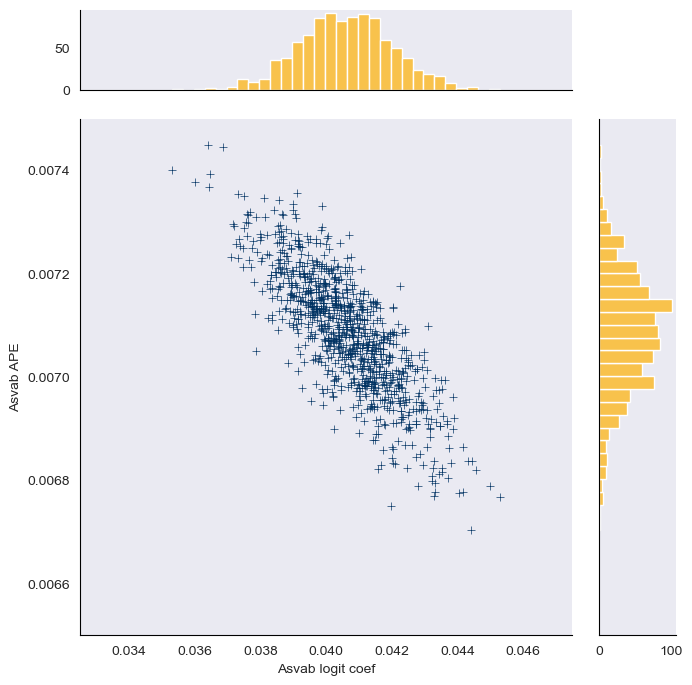

In [20]:
S = 1000                 # Number of bootstrap samples
M = np.empty((S,2))      # Matrix with posterior draws of statistics of interest
N = len(Y)               # Number of observations in dataset

# Compute average partial effect of asvab score using observed sample-in-hand
Xb = X @ model.coef_.T                                                      # Compute linear index
ape_hat_asvab = np.mean((np.exp(Xb)/(1+np.exp(Xb))**2)*model.coef_[0,-1])   # Compute APE estimate

print("")
print(f"Logit estimate of the average partial effect of 1-unit increase asvab percentile: {ape_hat_asvab:.4f}")

# Perform s=1,...,S bootstrap simulations    
for s in range (0,S):
    sth_sample = nlsy97.sample(n=N, replace=True)  # Take bth bootstrap sample
    X = sth_sample[['intercept', 'female', 'black', 'hispanic', 'asvab']]
    Y = sth_sample['college']
    model_s = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
    M[s,0] = model_s.coef_[0,-1]                                        # Save coef. on asvab  
    Xs = X @ model_s.coef_.T                                            # Compute linear index
    M[s,1] = np.mean((np.exp(Xs)/(1+np.exp(Xs))**2)*model.coef_[0,-1])  # sth bootstrap APE estimate 
    
# Save Efron Bootstrap result in a dataframe
EB=pd.DataFrame({'Asvab logit coef':M[:,0], 'Asvab APE':M[:,1]})

alpha = 0.05                                                            # target size

print("")
print(EB.quantile([alpha/2, 1-alpha/2]))

# Construct percentile and reverse percentile confidence intervals
lower_bnd = EB.quantile([alpha/2, 1-alpha/2]).iloc[(0,1)]
upper_bnd = EB.quantile([alpha/2, 1-alpha/2]).iloc[(1,1)]
print("")
print(f'A basic percentile boostrap confidence interval for asvab APE is: {lower_bnd:.6f} to {upper_bnd:.6f}')

# Construct bootstrap standard error using the percentile interval
norm_ref = sp.stats.norm(loc=0, scale=1)                         # Standard normal reference distribution
se_ape = (upper_bnd-lower_bnd)/(norm_ref.ppf(1-alpha/2)-norm_ref.ppf(alpha/2))
print(f'Standard error (from percentile interval): {se_ape:.6f}')

lower_bnd = 2*ape_hat_asvab - EB.quantile([alpha/2, 1-alpha/2]).iloc[(1,1)]
upper_bnd = 2*ape_hat_asvab - EB.quantile([alpha/2, 1-alpha/2]).iloc[(0,1)]
print("")
print(f'A reverse percentile boostrap confidence interval for asvab APE is: {lower_bnd:.6f} to {upper_bnd:.6f}')

# Construct bootstrap standard error using the reverse percentile interval
se_ape = (upper_bnd-lower_bnd)/(norm_ref.ppf(1-alpha/2)-norm_ref.ppf(alpha/2))
print(f'Standard error (from reverse percentile interval): {se_ape:.6f}')

# Scatter (use seaborn add-on to matplotlib)
sns.set_style("dark", {'axes.linewidth': 2, 'axes.edgecolor':'black'})
sns.jointplot(x="Asvab logit coef",y="Asvab APE", data=EB, kind="scatter", \
              height=7, space=0.35, color="#003262", xlim=(0.0325,0.0475), ylim=(0.0065,0.0075), marker='+',
              marginal_ticks=True, marginal_kws=dict(bins=30, fill=True, color='#FDB515', linewidth=1))

# Save the figure
plt.savefig(graphics + 'Figure_Reverse Percentile_Bootstrap_Asvab_APE.png', dpi=300, bbox_inches='tight')
plt.show()    

### Part IV: Assessing `balance'

This final snippet of code constructs a so-called propensity score balance plot. Plots like this one will feature in our discussion of program evaluation and covariate adjustment later in the semester. Note the use of the official [UC Berkeley color pallete](https://brand.berkeley.edu/visual-identity/colors/) in the plot!

In [21]:
X = nlsy97[['intercept', 'female', 'black', 'hispanic', 'asvab']]
Y = nlsy97['college']

model = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
model.coef_

nlsy97['pscore'] = model.predict_proba(X)[:,1] # col 0 gives Pr(Y=0|X),  col 1 gives Pr(Y=1|X)
ps_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = ['ps_D01', 'ps_D02', 'ps_D03','ps_D04','ps_D05','ps_D06','ps_D07','ps_D08','ps_D09','ps_D10']
nlsy97['ps_level'] = pd.cut(nlsy97['pscore'], bins=ps_bins, labels=labels, right=False)

In [22]:
pd.crosstab(nlsy97['college'], nlsy97['ps_level'], normalize=True, margins=True)

ps_level,ps_D01,ps_D02,ps_D03,ps_D04,ps_D05,ps_D06,ps_D07,ps_D08,ps_D09,All
college,,,,,,,,,,
0,0.148258,0.175574,0.099565,0.069477,0.057799,0.045724,0.036421,0.019794,0.001584,0.654196
1,0.010293,0.032858,0.035629,0.035629,0.041568,0.054632,0.068488,0.060768,0.005938,0.345804
All,0.158551,0.208432,0.135194,0.105107,0.099367,0.100356,0.104909,0.080562,0.007522,1.000000


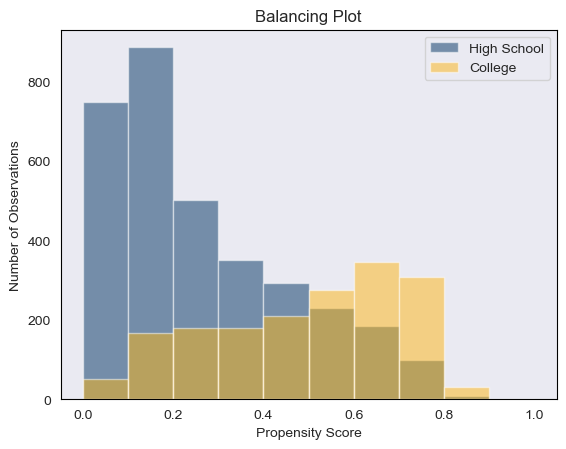

In [23]:
# Create propensity score balance figure
fig, ax = plt.subplots()

# Plot the histograms
ax.hist(nlsy97['pscore'].loc[(nlsy97['college'] == 0)], bins=ps_bins, alpha=0.5, label='High School', color='#003262')
ax.hist(nlsy97['pscore'].loc[(nlsy97['college'] == 1)], bins=ps_bins, alpha=0.5, label='College', color='#FDB515')

# Add labels and title
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Number of Observations')
ax.set_title('Balancing Plot')

# Add legend
ax.legend()

# Show the plot
plt.show()